In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string
import warnings
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet', quiet=True)

[nltk_data] Downloading package vader_lexicon to /Users/tgtrwe-
[nltk_data]     lt-0098/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#Read in training data

df = pd.read_csv('drugsComTrain_raw.csv')
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
#Shape of data
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset')

There are 161297 rows and 7 columns in the dataset


In [4]:
#Check for null values
df.isna().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [5]:
#What % of data do these represent?
print( f' Null values represent {round(df.isna().sum()[2]/len(df) * 100, 1)}% of the dataset')

 Null values represent 0.6% of the dataset


## Comments:
* Rows where condition is not present represent < 1% of the total dataset. Let's remove.

In [6]:
df = df.dropna()

In [7]:
#Check dtypes
df.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

## Comments:
* Everything is text or integer. Looks ok. Except let's convert date to datetime

In [8]:
#Converting to datetime
df['date'] = pd.to_datetime(df['date'])

# EDA

In [9]:
#Total unique drug names?
print(f'{df["drugName"].nunique()} unique drugs in dataset')

3431 unique drugs in dataset


In [10]:
#Average number of reviews for each drug?

tot_dr = pd.DataFrame(df.groupby(['drugName'])['uniqueID'].count().sort_values(ascending=False)).reset_index()
tot_dr = tot_dr.rename(columns = {'uniqueID':'Count'})

tot_dr['Count'].describe()

count    3431.000000
mean       46.749636
std       163.163396
min         1.000000
25%         2.000000
50%         5.000000
75%        26.000000
max      3631.000000
Name: Count, dtype: float64

## Comments:
* There are on average 46 reviews for each drug

In [11]:
#How many unique drugs had less than 5 reviews?
tot_dr['drugName'][tot_dr['Count'] < 5].nunique()

1588

In [12]:
#What percentage of total drugs reviewed was this?
print( f'{round(tot_dr["drugName"][tot_dr["Count"] < 5].nunique()/len(tot_dr) * 100,1)}% of all drugs had less than 5 reviews')

46.3% of all drugs had less than 5 reviews


## Comments:
* Seems like only a few drugs mights be driving most of the reviews. Let's see the total percentage

In [13]:
#Look at top 50
top_50 = round(tot_dr.nlargest(n = 50, columns = 'Count').sum()[1]/tot_dr['Count'].sum()*100,1)
print(f'The top 50 drugs with the most reviews make up {top_50}% of the total reviews')

The top 50 drugs with the most reviews make up 32.9% of the total reviews


In [14]:
#What are the names of these drugs with counts?

tot_dr.head(50)

,drugName,Count
0,Levonorgestrel,3631
1,Etonogestrel,3321
2,Ethinyl estradiol / norethindrone,2750
3,Nexplanon,2156
4,Ethinyl estradiol / norgestimate,2033
5,Ethinyl estradiol / levonorgestrel,1809
6,Phentermine,1538
7,Sertraline,1353
8,Escitalopram,1287
9,Mirena,1242


## Comments:
* Most of these appear to be contraceptives,birth control, etc. Let's look by drug indication. Some of these drugs have more than one indication such as Levonorgestrel

In [15]:
tot_dr_ind = pd.DataFrame(df.groupby(['condition'])['uniqueID'].count().sort_values(ascending=False)).reset_index()
tot_dr_ind = tot_dr_ind.rename(columns = {'uniqueID':'Count'})

tot_dr_ind['percent_total_reviews']  = round(tot_dr_ind['Count'] / tot_dr_ind['Count'].sum() * 100,1)

In [16]:
tot_dr_ind.head()

,condition,Count,percent_total_reviews
0,Birth Control,28788,17.9
1,Depression,9069,5.7
2,Pain,6145,3.8
3,Anxiety,5904,3.7
4,Acne,5588,3.5


## Comments:
* Most of reviews are for Birth Control. Let's look at other conditions

In [17]:
pd.DataFrame(data = list(tot_dr_ind['condition'].unique()), columns=['condition']).sort_values(by='condition',ascending=True).head(80)

,condition
144,0</span> users found this comment helpful.
287,10</span> users found this comment helpful.
780,110</span> users found this comment helpful.
432,11</span> users found this comment helpful.
768,121</span> users found this comment helpful.
...,...
851,AV Heart Block
721,Abdominal Distension
14,Abnormal Uterine Bleeding
479,Abortion


## Comments: 
* This is a sorted series of the different conditions each drug treats found during EDA. Looks like some of them have the number of users who found helpful as the drug name. Let's see if we an replace these with condition that drug treats where it is actually listed

In [18]:
#Make a list of drugs where there were comments helpful marked
com_drugs = list(df['drugName'][df['condition'].str.contains('comment helpful')])

#Put all these drugs into a dataframe
com_drugs_df = df[['drugName','condition']][df['drugName'].isin(com_drugs)]

#See count of unique conditions each drug treats
com_drugs_df_c = pd.DataFrame(com_drugs_df.groupby('drugName')['condition'].nunique()).reset_index()

com_drugs_df_c[com_drugs_df_c['condition'] == 1]

,drugName,condition
7,Aerobid-M,1
8,Alavert D-12 Hour Allergy and Sinus,1
67,Dantrium,1
109,Fleet Phospho Soda,1
113,Fluoridex,1
115,Fragmin,1
123,Hair Regrowth Treatment for Women,1
144,Lescol,1
160,Lotrimin AF Athlete's Foot Powder,1
167,Maxidex,1


In [19]:
drugs_one_cond = list(com_drugs_df_c['drugName'][com_drugs_df_c['condition'] == 1].unique())

df[df['drugName'].isin(drugs_one_cond)].sort_values(by='drugName',ascending=True)

,uniqueID,drugName,condition,review,rating,date,usefulCount
31706,131185,Aerobid-M,1</span> users found this comment helpful.,"""Fantastic, the mentholated one is great &amp;...",10,2014-09-28,1
678,80302,Alavert D-12 Hour Allergy and Sinus,1</span> users found this comment helpful.,"""I&#039;ve found this product helps to shrink ...",5,2016-04-15,1
75127,204288,Dantrium,98</span> users found this comment helpful.,"""I was hit by an uninsured drunk driver in &#0...",10,2008-12-25,98
117087,69138,Fleet Phospho Soda,6</span> users found this comment helpful.,"""This site provided information not on the bot...",6,2008-09-07,6
152441,8055,Fluoridex,6</span> users found this comment helpful.,"""My dentist suggested using it regularly after...",10,2013-03-14,6
96406,32784,Fragmin,4</span> users found this comment helpful.,"""Information was clear to understand.""",10,2008-05-14,4
92511,20813,Hair Regrowth Treatment for Women,14</span> users found this comment helpful.,"""W/in 2 hours of application I was cramping. P...",1,2016-11-21,14
50221,195158,Lescol,25</span> users found this comment helpful.,"""Lescol lowered my LDL cholesterol from 270 to...",9,2008-08-31,25
107948,36113,Lotrimin AF Athlete's Foot Powder,1</span> users found this comment helpful.,"""Product works but the dispenser is terrible. ...",9,2010-07-16,1
38284,14325,Maxidex,4</span> users found this comment helpful.,"""I was in coma for 3 weeks. When i eventually ...",6,2016-10-15,4


## Comments:
* The drugs that only treated one condition with "comment helpful" for the conditions were few as you can see above. All the other drugs that had a this as the condition had multiple conditions it could treat. Therefore, it would be hard to know the condition it was prescribed for for these to fill them in. Going to drop these rows

In [20]:
df = df[~df['condition'].str.contains('comment helpful')]

In [21]:
#Which drug class had the highest rating with at least 50 reviews?
cond_mean_ct = df.groupby('condition')['rating'].agg(['mean','count']).reset_index()
cond_mean_ct = cond_mean_ct[cond_mean_ct['count'] > 50]
cond_mean_ct.nlargest(columns = 'mean', n=20)

,condition,mean,count
791,mance Anxiety,9.673797,187
20,Alcohol Withdrawal,9.244240,217
191,Dermatitis,9.096774,93
150,Cold Sores,9.068120,367
328,Hyperhidrosis,8.935007,677
19,Alcohol Dependence,8.894330,388
82,Barrett's Esophagus,8.864865,74
242,Erosive Esophagitis,8.842857,70
308,"Herpes Simplex, Suppression",8.789157,166
146,Cluster Headaches,8.771084,166


In [22]:
#Which drug class had the lowest rating with at least 50 reviews?
cond_mean_ct = df.groupby('condition')['rating'].agg(['mean','count']).reset_index()
cond_mean_ct = cond_mean_ct[cond_mean_ct['count'] > 50]
cond_mean_ct.nsmallest(columns = 'mean', n=20)

,condition,mean,count
751,Vaginal Yeast Infection,4.082234,2274
4,Abnormal Uterine Bleeding,4.372615,2096
597,Prostatitis,4.560440,91
513,Osteoporosis,4.833333,372
161,"Constipation, Drug Induced",5.083333,228
93,Bladder Infection,5.144304,395
215,Dry Eye Disease,5.149660,147
745,Urinary Tract Infection,5.335866,1316
385,Keratoconjunctivitis Sicca,5.425926,54
62,"Asthma, acute",5.444444,135


## Comments:
* There are many different drugs and conditions in this dataset. For purposes of this project, I am only interested in drugs that treat mental health conditions. Going to remove anything not related to this

## Search for drugs that treat mental health conditions in the dataset

In [23]:
#I found an html table at https://denalirx.com/top-200-drugs-list that lists the drug class for the top 200 drugs(assuming prescribed?)drugs. We can add the drug class to our dataset for the drugs
#that are found. This will make it easier to look for conditions related to mental health

df_dc = pd.read_html(io = 'https://denalirx.com/top-200-drugs-list')[0]

#Rename column names since they imported with special characters
mapping = {df_dc.columns[0]:'Generic Name', df_dc.columns[1]: 'Brand Name'}
df_dc = df_dc.rename(columns=mapping)

#See the new dataframe with the drug name and classes
df_dc

,Generic Name,Brand Name,Drug Class,DEA Schedule
0,Levothyroxine,Synthroid,Hormone replacement,-
1,Hydrocodone/APAP,Vicodin,Analgesic,C-II
2,Amoxicillin,Amoxil,Antibiotic,-
3,Lisinopril,Prinivil,Antihypertensive,-
4,Esomeprazole,Nexium,Antacid (PPI),-
...,...,...,...,...
195,Lomitapide,Juxtapid,Cholesterol lowering,-
196,Tizanidine,Zanaflex,Muscle Relaxer,-
197,Amphetamine / Dextroamphetamine,Adderall,ADHD,C-II
198,Zoster Vaccine,Zostavax,Shingles Vaccine,-


In [24]:
#Merge this with the original dataframe on both brand name and generic name to get the drug class
df = pd.merge(df,df_dc[['Brand Name','Drug Class']],left_on='drugName',right_on='Brand Name',how='left')
df = pd.merge(df,df_dc[['Generic Name','Drug Class']],left_on='drugName',right_on='Generic Name',how='left')

#Fill drug class with drug class from generic name for the drug
df['Drug Class_x'] = np.where( (df['Drug Class_x'].isna()==True) & (df['Drug Class_y'].isna()==False), df['Drug Class_y'], np.nan)

#Rename Drug Class_x as Drug Class
df = df.rename(columns = {'Drug Class_x':'Drug Class'})

#Drop other columns you do not need
df = df.drop(columns = 'Drug Class_y')

df

,uniqueID,drugName,condition,review,rating,date,usefulCount,Brand Name,Drug Class,Generic Name
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,NaN,Antihypertensive,Valsartan
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,NaN,NaN,NaN
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,NaN,NaN,NaN
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,NaN,NaN,NaN
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
159493,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,2015-05-31,125,NaN,NaN,NaN
159494,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,2011-11-01,34,NaN,Antispasmodic,Metoclopramide
159495,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,2014-03-15,35,NaN,NaN,NaN
159496,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,2015-09-19,79,NaN,NaN,NaN


In [25]:
#See a list of all the unique drug classes
list(df['Drug Class'].unique())

['Antihypertensive',
 nan,
 'Antipsychotic',
 'Anticonvulsant',
 'Antidiabetic',
 'Antidepressant',
 'Antiepileptic',
 'Anti-arthritic',
 'Antibiotic',
 'Antifungal',
 'Antianxiety',
 'Urinary retention',
 'Erectile dysfunction',
 'Analgesic',
 'Diuretic',
 "Anti-Parkinson's",
 'Analgesic (NSAID)',
 'Antitussive (cough suppressant)',
 'Cholesterol lowering',
 'Hormone replacement',
 'ADHD',
 'Muscle Relaxer',
 'Opioid addiction',
 'Anti-asthmatic',
 'Antacid (PPI)',
 'Antiviral',
 'Antispasmodic',
 'Antiemetic',
 'Sleep aid',
 'Anti-smoking',
 'Incontinence',
 'Antimigraine',
 'Appetite suppressant',
 'Antihistamine',
 'Antirheumatic',
 'Antigout',
 'Antacid (H2)',
 'Anti-inflammatory steriod',
 'Analgesic (urinary)',
 'C.O.P.D.',
 'Sleep Aid',
 'Immunosuppressant',
 'Anticoagulant',
 'Osteoporosis',
 'Bladder relaxant',
 'Urinary retention / Antihypertensive',
 'Antidementia',
 'Congestive Heart Failure',
 'Antiglaucoma',
 'Anti-inflammatory']

## Comments:
 * Going to focus on only these drug classes for mental health for this project going forward. Antipsychotic, Antidepressant, Antianxiety, ADHD, Opioid addiction, Antidementia  

In [26]:
#Get a new dataframe to only focus on drug classes interested in

df = df[ df['Drug Class'].isin(['Antidepressant','Antipsychotic','Antianxiety','ADHD','Opioid addiction','Antidementia'])]

# Mental Health Drugs EDA

* Often times there are certain words that are capitalized in the reviews. Interested in exploring how number of capitalized words could influence the
  useful counts

In [27]:
#Classify ratings into negative, neutral or positive

df['rating_class'] = np.where(df['rating'] <= 3, 'Negative',np.nan)
df['rating_class'] = np.where((df['rating'] > 3) & (df['rating'] <=7), 'Neutral',df['rating_class']) 
df['rating_class'] = np.where(df['rating'] > 7, 'Positive',df['rating_class'])  

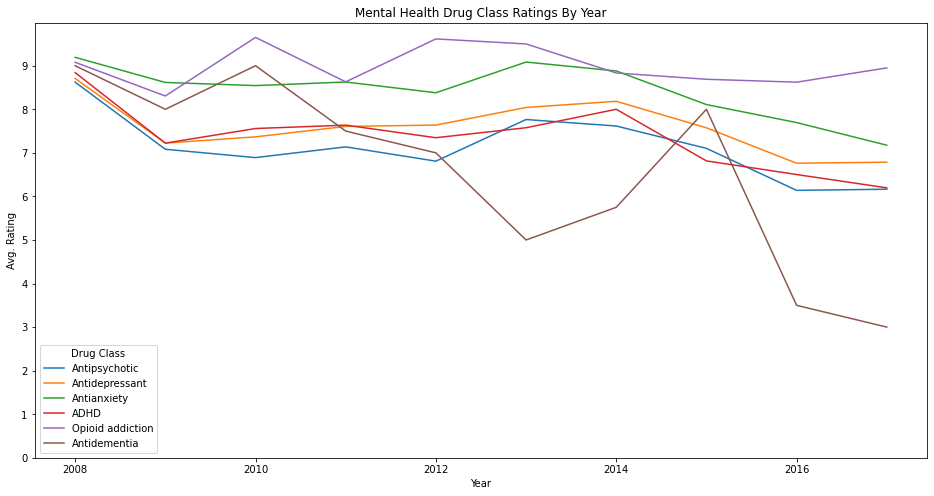

In [28]:
#Look at average ratings over the years

#Convert date to yyyy/qr
df['date_yq'] = df['date'].dt.year.astype(str) + 'Q' + df['date'].dt.quarter.astype(str)
df['date_yr'] = df['date'].dt.year

plt.figure(figsize=(16,8))
plt.title('Mental Health Drug Class Ratings By Year')
sns.lineplot(data=df, x = 'date_yr', y = 'rating', hue = 'Drug Class',ci=None)
plt.ylabel('Avg. Rating')
plt.yticks(np.arange(0,10,1))
plt.xlabel('Year');

## Comments:
 * Consistent drop of average rating of mental heath drug classes except Opioids over last 10 years, especially Antidementia drugs. Let's explore Antidementia drugs
    closer

In [29]:
antidem = df[df['Drug Class'] ==  'Antidementia']

antidem.groupby(['drugName','date_yr'])['rating'].agg(['mean','count'])

mean  count
drugName     date_yr                  
Memantine    2011      5.000000      1
             2013      5.000000      2
             2014      5.000000      3
             2015      9.000000      2
             2016      4.333333      3
             2017      3.500000      4
Rivastigmine 2008      9.000000      1
             2009      8.000000      1
             2010      9.000000      1
             2011     10.000000      1
             2012      7.000000      1
             2014      8.000000      1
             2015      7.333333      3
             2016      1.000000      1
             2017      1.000000      1

## Comments:

* Small number of reviews for antidementia drugs. High variability because of this.

### Let's look at drugs in the antidepressant class as these have the most reviews and have seen a decline in avg. reviews since 2014

In [30]:
df.groupby('Drug Class')['uniqueID'].count().sort_values(ascending=False)

Drug Class
Antidepressant      10100
Antianxiety          2737
Antipsychotic        2182
ADHD                 1217
Opioid addiction      327
Antidementia           26
Name: uniqueID, dtype: int64

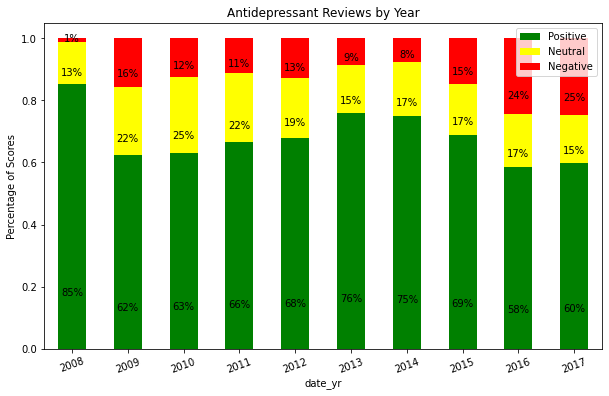

In [31]:
#Make dataframe just for antidepressants
antidep = df[['drugName','condition','rating','rating_class','date','date_yr']][df['Drug Class'] ==  'Antidepressant']

#Make dummies column for positive, negative and neutral reviews
antidep = pd.concat([antidep.drop('rating_class', axis=1), pd.get_dummies(antidep['rating_class'])], axis=1)

antidep_pos = pd.DataFrame(antidep.groupby('date_yr')['Positive'].sum()/antidep.groupby('date_yr')['Positive'].count()).reset_index()
antidep_neu = pd.DataFrame(antidep.groupby('date_yr')['Neutral'].sum()/antidep.groupby('date_yr')['Neutral'].count()).reset_index()
antidep_neg = pd.DataFrame(antidep.groupby('date_yr')['Negative'].sum()/antidep.groupby('date_yr')['Negative'].count()).reset_index()

antidep_final = antidep_pos.merge(antidep_neu,on='date_yr').merge(antidep_neg,on='date_yr')


ax = antidep_final.set_index('date_yr').plot.bar(stacked = True, title='Antidepressant Reviews by Year',  figsize=(10,6), rot=20, ylabel = 'Percentage of Scores', color=['green','yellow','red'])



# Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*.2), ha='center')

## Comments:

* Big percentage increase in negative reviews starting in 2015. Let's see if that is consistent with other drug classes

In [32]:
def drug_class_review(drugclass):
    
    #Make dataframe just for antidepressants
    d_class = df[['drugName','condition','rating','rating_class','date','date_yr']][df['Drug Class'] == str(drugclass)]

    #Make dummies column for positive, negative and neutral reviews
    d_class = pd.concat([d_class.drop('rating_class', axis=1), pd.get_dummies(d_class['rating_class'])], axis=1)

    d_class_pos = pd.DataFrame(d_class.groupby('date_yr')['Positive'].sum()/d_class.groupby('date_yr')['Positive'].count()).reset_index()
    d_class_neu = pd.DataFrame(d_class.groupby('date_yr')['Neutral'].sum()/d_class.groupby('date_yr')['Neutral'].count()).reset_index()
    d_class_neg = pd.DataFrame(d_class.groupby('date_yr')['Negative'].sum()/d_class.groupby('date_yr')['Negative'].count()).reset_index()

    d_class_final = d_class_pos.merge(d_class_neu,on='date_yr').merge(d_class_neg,on='date_yr')


    ax = d_class_final.set_index('date_yr').plot.bar(stacked = True, title= f'{drugclass} Reviews by Year',  figsize=(10,6), rot=20, ylabel = 'Percentage of Scores', color=['green','yellow','red'])


    # Add this loop to add the annotations
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
    
        ax.annotate(f'{height:.0%}', (x + width/2, y + height*.2), ha='center')
    
    return ax

<AxesSubplot:title={'center':'Opioid addiction Reviews by Year'}, xlabel='date_yr', ylabel='Percentage of Scores'>

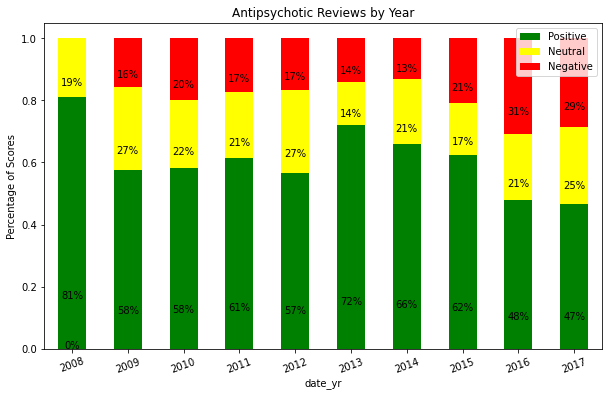

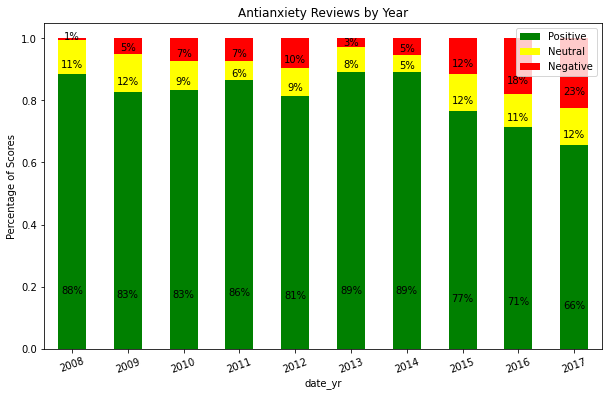

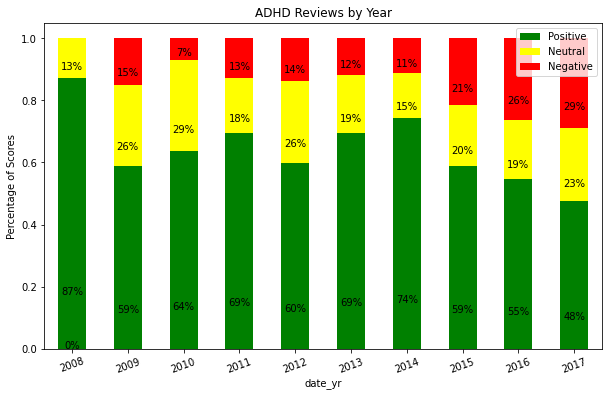

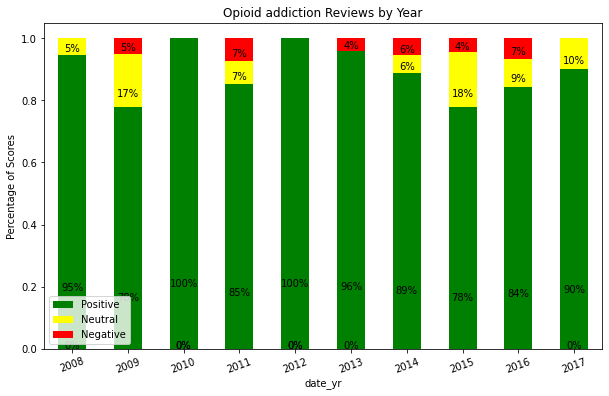

In [33]:
drug_class_review('Antipsychotic')
drug_class_review('Antianxiety')
drug_class_review('ADHD')
drug_class_review('Opioid addiction')

In [46]:
import yake

#doc = df.iloc[[1]]
#doc = str(test['review'])
full_text = "I've been taking amitriptyline since January 2013 after being diagnosed with fibromyalgia. I tried cymbalta for a week and my Dr decided that since it kept me awake 24/7 that it wasn&#039;t a good fit for me even though it relieved my pain. I started with 25 mg. After 2 weeks I had some breakthrough pain, so my Dr increased my dosage to 50mg and I&#039;m still on that dosage today. For the first full year I was on this I never had pain and felt &#039;cured&#039;. As time went on, it seems to help control my pain. I do still have pain, but at a low manageable level. I take this around 7pm each evening to avoid feeling overly drowsy in the mornings. This med allows me to have a fairly normal life."

kw_extractor = yake.KeywordExtractor(top=150, stopwords=None)
keywords = kw_extractor.extract_keywords(full_text)
for kw, v in keywords:
  print("Keyphrase: ",kw, ": score", v)


#pd.set_option("display.max_colwidth", -1)

Keyphrase:  amitriptyline since January : score 0.0108087725345513
Keyphrase:  diagnosed with fibromyalgia : score 0.02658294871340398
Keyphrase:  taking amitriptyline : score 0.031336728430753844
Keyphrase:  January : score 0.061345228746420594
Keyphrase:  pain : score 0.08890700846420313
Keyphrase:  fibromyalgia : score 0.1485533746847474
Keyphrase:  taking : score 0.17431171861849065
Keyphrase:  amitriptyline : score 0.17431171861849065
Keyphrase:  diagnosed : score 0.17431171861849065
Keyphrase:  good fit : score 0.21796299666844096
Keyphrase:  dosage : score 0.24968562726995147
Keyphrase:  breakthrough pain : score 0.336937486201153
Keyphrase:  dosage today : score 0.35045629982664167
Keyphrase:  awake : score 0.37731629488699814
Keyphrase:  cymbalta : score 0.42303308852233884
Keyphrase:  decided : score 0.42303308852233884
Keyphrase:  good : score 0.42303308852233884
Keyphrase:  fit : score 0.42303308852233884
Keyphrase:  relieved : score 0.42303308852233884
Keyphrase:  week : s

In [ ]:
df.iloc[[1]]

In [ ]:
antidep = df[df['Drug Class'] == 'Antidepressant']

antidep = pd.DataFrame(antidep.groupby(['date_yr','condition'])['uniqueID'].count()).reset_index()


plt.figure(figsize=(16,8))
sns.countplot(data = antidep, x = 'date_yr')

In [ ]:
# #Make custom list for words that should not be included as uppercase. These are often abbreviations or the description of the condition the person has

# mh_list = ['AA','AD','AAF','AAP','PCP','AB','BP','AC','ACL','OCD','ADHD','ADHDADD','ADD','ADDADHD','ADHA','ADHDIA','ADHDPI','AHHD','AMPM','ARNP'
#            'GAD','GI','GF','IBS','XR','ER','MG','MD','DR','PTSD','SSRI','SR','GP','BPII','BUTI','CDPHP','CPAP','CPEP','CFSME','GADOCD','MHNI']


# def clean_text():
#     """
#     Cleans the review text field
#     """
#     #Strip punctuation
#     df['review_clean'] = df['review'].str.replace('[^\w\s]','')

#     #Strip numbers
#     df['review_clean'] = df['review_clean'].str.replace('\d+', '')
    
    
# def text_length(text):
    
#     """
#     Count number of words in the text
#     """
    
#     text = text.strip()
    
#     total = 0
    
#     for word in text.split():
#         total += 1
        
#     return total
        
# def uppercase(text):
    
#     """
#     Returns a list of only selected uppercase words
#     and are not in custom list
#     """
    
#     text = text.strip()
    
#     total = []
    
#     for word in text.split():
#         if word.isupper() and len(word) > 1 and word not in mh_list:
#             total.append(word)
#     return ', '.join(total)


# def uppercase_count(text):
    
        
#     """
#     Returns a count of only selected uppercase words
#     and are not in custom list
#     """
    
#     text = text.strip()
    
#     total = 0
    
#     for word in text.split():
#         if word.isupper() and len(word) > 1 and word not in mh_list:
#             total += 1
#     return total


# def PosSentimentAnalyzer(text):
#     """
#     Returns count of capitalized words frm ntlk sentiment polarity that are positively
#     charged (i.e > .50)
#     """
    
#     sia = SentimentIntensityAnalyzer()
    
#     text = text.strip()
    
#     total = []
    
#     for word in text.split():
#         if (sia.polarity_scores(word)['compound']) >= 0.5:
#             total.append(word)  
#     return', '.join(total)


# def PosSentimentAnalyzerCount(text):
#     """
#     Returns count of capitalized words frm ntlk sentiment polarity that are positively
#     charged (i.e > .50)
#     """
    
#     sia = SentimentIntensityAnalyzer()
    
#     text = text.strip()
    
#     total = 0
    
#     for word in text.split():
#         if (sia.polarity_scores(word)['compound']) >= 0.5:
#             total += 1  
#     return total

# def NegSentimentAnalyzer(text):
#     """
#     Returns count of capitalized words from ntlk sentiment polarity that are negatively
#     charged (i.e > .50)
#     """
    
#     sia = SentimentIntensityAnalyzer()
    
#     text = text.strip()
    
#     total = []
    
#     for word in text.split():
#         if (sia.polarity_scores(word)['compound']) <= -0.5:
#             total.append(word)  
#     return', '.join(total)


# def NegSentimentAnalyzerCount(text):
#     """
#     Returns count of capitalized words frm ntlk sentiment polarity that negatively charged
#     charged (i.e > .50)
#     """
    
#     sia = SentimentIntensityAnalyzer()
    
#     text = text.strip()
    
#     total = 0
    
#     for word in text.split():
#         if (sia.polarity_scores(word)['compound']) <= -0.5:
#             total += 1  
#     return total




# #Make columns for length of review, uppercase words and counts and positive or negative sentiment of word
# clean_text()
# df['review_length'] = df['review'].apply(text_length)
# df['uppercase'] = df['review_clean'].apply(uppercase)
# df['uppercase_count'] = df['review_clean'].apply(uppercase_count)
# df['uppercase_positive'] = df['uppercase'].apply(PosSentimentAnalyzer)
# df['uppercase_positive_count'] = df['uppercase'].apply(PosSentimentAnalyzerCount)
# df['uppercase_negative'] = df['uppercase'].apply(NegSentimentAnalyzer)
# df['uppercase_negative_count'] = df['uppercase'].apply(NegSentimentAnalyzerCount)